# Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.

Number of reviews: 568,454
Number of users: 256,059
Number of products: 74,258
Timespan: Oct 1999 - Oct 2012
Number of Attributes/Columns in data: 10

<br>
#### Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review

#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

Note: I have taken only 5000 reviews for this purpose because of computational constraints. 

In [1]:
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer



# [0] Loading the Data



In [2]:
# Importing the data
df = pd.read_csv('../input/Reviews.csv')
data = df[df.Score!=3][0:5000]

# Performing Basic Checks
print('The Shape of the data'+str(data.shape)+'\n')
print('Data Types of all columns\n',data.dtypes,'\n')
print('Checking for Na Values\n',data.isna().sum())
data.head(5)

The Shape of the data(5000, 10)

Data Types of all columns
 Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object 

Checking for Na Values
 Id                        0
ProductId                 0
UserId                    0
ProfileName               0
HelpfulnessNumerator      0
HelpfulnessDenominator    0
Score                     0
Time                      0
Summary                   0
Text                      0
dtype: int64


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


1. There are 10 features.
2. No Na values present in the text data. For our objective the text is all we need.

# [1] Data Cleaning

In [3]:
# Converting score to 1(positive) or 0(negative)
def score(x):
    '''This function converts the score into positive or negative'''
    if x<3:
        return 0
    elif x>3:
        return 1
positivenegative = data['Score'].map(score)
data['score'] = positivenegative
data.drop('Score',axis=1,inplace=True)
data.head(5)    



,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,score
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1


In [4]:
# Checkes: 1. Numerator<=Denominator
print(data[data.HelpfulnessNumerator>data.HelpfulnessDenominator])

# 2. Duplication
data[data.duplicated(subset={'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'score'})]


Empty DataFrame
Columns: [Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Time, Summary, Text, score]
Index: []


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,score
29,30,B0001PB9FY,A3HDKO7OW0QNK4,Canadian Fan,1,1,1107820800,The Best Hot Sauce in the World,I don't know if it's the cactus or the tequila...,1
2309,2310,B0001VWE0M,AQM74O8Z4FMS0,Sunshine,0,0,1127606400,Below standard,Too much of the white pith on this orange peel...,0
2323,2324,B0001VWE0C,AQM74O8Z4FMS0,Sunshine,0,0,1127606400,Below standard,Too much of the white pith on this orange peel...,0
3885,3886,B005GX7GVW,AS1FCKNKY95ID,"Juli A. Lee ""JingleJL""",1,1,1336953600,Great and good price!,I love these noodles. They are really great f...,1
3886,3887,B005GX7GVW,A1I34N9LFOSCX7,Smeggy,0,0,1349136000,Yum!,This soup cooks up quickly and is very yummy! ...,1
4640,4641,B0002NYO9I,A5DVX3B075B09,Patricia Kays,0,0,1338940800,LOVELY JUNIPER BERRIES,"Dried berries, still with texture and the quin...",1
4641,4642,B0002NYO9I,A376TWN7I4HMZ8,helios,0,1,1324252800,Exaclty what i ordered,"Again, exactly what I ordered. No fuss, no mus...",1


* There are some duplicated values present. Lets print one out.

In [5]:
data[data.Text==data['Text'].iloc[2309]]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,score
2513,2514,B0079LSXQ6,ANEDXRFDZDL18,Serene,2,3,1336780800,Tasty,I picked up a box of this in a discount grocer...,1


In [6]:
# Deleting the values
data.drop_duplicates(keep='first',subset={'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'score'},inplace=True)
print(data[data.duplicated(subset={'ProfileName','HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Time', 'Summary', 'Text', 'score'})])
print(data.shape)
# All the duplicate values have been removed

Empty DataFrame
Columns: [Id, ProductId, UserId, ProfileName, HelpfulnessNumerator, HelpfulnessDenominator, Time, Summary, Text, score]
Index: []
(4993, 10)


1    4182
0     811
Name: score, dtype: int64


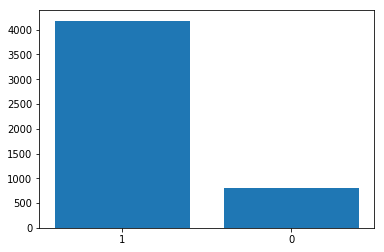

In [7]:
# Distribution of scores
print(data.score.value_counts())
c=[]
for i in data.score.value_counts():c.append(i)
plt.bar(['1','0'],c)
plt.show()


1. Dataset is imbalanced. We have 4182 positive reviews and 811 negative reviews.
2. We will have to oversample or undersample the data points while modelling

# [2] Text Pre processing

- All the punctuations, html tags and the stopwords need to be removed before analysing the text.
- Stopwords are frequently occuting words which do not offer any real meaning to the text. Eg: the, is, and, no etc.
- Stopwords may make sense when used along with a non-stopword like 'not good' where not is a stop word. 

*For now, we will remove all the stopwords and make a new feature called cleanedText*

In [8]:
from nltk.stem import SnowballStemmer
import nltk.stem
import re
import string

stop = set(stopwords.words('english'))
sno = nltk.SnowballStemmer('english')

 # Defining functions that will make our cleaning easier
def cleanhtml(sent):
    '''This function cleans the html tags ina  sentence'''
    cleanr = re.compile('<.*?>')
    clean_sentence = re.sub(cleanr,'',sent)
    return clean_sentence

def cleanpunc(word):
    '''This function cleans the punctuations in a word'''
    clean_word = re.sub(r'[?|!|,|.|\|/|\'|"|:|;|#]',r'',word)
    return clean_word

In [9]:
cleaned_text =[] # List of the cleaned reviews
for sentence in data['Text'].values:
    clean_sentence = []
    sentence = cleanhtml(sentence)
    for word in sentence.split():
        cleaned_word = cleanpunc(word)
        if (cleaned_word.lower() not in stop) & (cleaned_word.isalpha()):
            if len(cleaned_word)>2:
                stemmed_word = sno.stem(cleaned_word.lower()).encode('utf8')
                clean_sentence.append(stemmed_word)
            

    str1=b' '.join(clean_sentence)
    #print(str1)
    cleaned_text.append(str1)
print('Cleaned Text: ',cleaned_text[0])
print('\nActual Text: ',data['Text'].values[0])
data['cleanedText'] = cleaned_text
data.head(5)

Cleaned Text:  b'bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better'

Actual Text:  I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,score,cleanedText
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1,b'bought sever vital can dog food product foun...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,0,b'product arriv label jumbo salt peanutsth pea...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1,b'confect around centuri light pillowi citrus ...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,0,b'look secret ingredi robitussin believ found ...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1350777600,Great taffy,Great taffy at a great price. There was a wid...,1,b'great taffi great price wide assort yummi ta...


# [3] Data Modelling

## [3.1] Splitting the Data

- Splitting of the data can be done mainly in 2 was.
1. Random Splitting: The data is randomly split into train and test set where each datapoint as equal probability of going into the train or test set respectively.
2. Time Based Splitting: Train, Cross Validation and Test set is formed in ascending order of time.


- We have used time based splitting as the data in internet companies keep changing over time. If we use random splitting then we might get a good accuracy on train or cross validation data but
on futue unseen data we will get a lower accuracy.


In [10]:
from sklearn.model_selection import train_test_split
y = data['score']
data.drop('score',axis=1,inplace = True)
X = data
print(X.shape)
print(y.shape)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33,shuffle =False) # 33% data in test
X_train,X_cv,y_train,y_cv = train_test_split(X_train,y_train,test_size = 0.33,shuffle =False) # 33% data in cross validation
print('Train shape ',X_train.shape,y_train.shape)
print('CV shape',X_cv.shape,y_cv.shape)
print('Test shape',X_test.shape,y_cv.shape)


(4993, 10)
(4993,)
Train shape  (2241, 10) (2241,)
CV shape (1104, 10) (1104,)
Test shape (1648, 10) (1104,)


## [3.2] Bag of Words

- BOW is a technique used to convert textual data into numeric data. 
- It creates a sparse matrix where the features are the vocabulary built using the train data and the values are the frequency of those terms in the document.

In [11]:
# Converting cleaned text into bow vectors

bow = CountVectorizer(max_features = 500) #ngram = 1


Xtrain_bow = bow.fit_transform(X_train['cleanedText'])
print(bow.get_feature_names()[0:10])
#print(bow.vocabulary_)

Xcross_bow = bow.transform(X_cv['cleanedText'])
Xtest_bow = bow.transform(X_test['cleanedText'])

# Checking their dimension
print(Xtrain_bow.shape)
print(Xcross_bow.shape)
print(Xtest_bow.shape)
# Reduced the reviews bow vectors with 500 features



['abl', 'absolut', 'actual', 'ad', 'add', 'addict', 'addit', 'ago', 'allergi', 'almost']
(2241, 500)
(1104, 500)
(1648, 500)


## [3.2.1] Standardizing

In [12]:
# Standardizing
from sklearn.preprocessing import StandardScaler
std = StandardScaler()

Xtrain_bow_std = std.fit_transform(Xtrain_bow.toarray()) # converting sparse matrix into dense matrix using toarray()
Xtest_bow_std = std.fit_transform(Xtest_bow.toarray())
Xcross_bow_std = std.fit_transform(Xcross_bow.toarray())


## [3.2.2] Train and Test Distribution

- Since we have done a time based split we must ensure that the distribution of train and test are not too dissimilar.
- As mentioned before, the data in internet companies keeps chaning over time, this may lead to 2 completely different distribution in 2 points of time. The train and test dat
may be completely different and if that is the case then our model will perform horribly.

#### Process

- To ensure that train and test are of similar distribution we are applying KNN classification.
- A new dataset has been created where label=1 is given to train and label = 0 is given to test.
- Then, we are modelling a classifier to distinguish between the train and test.
- If the accuracy is high then that means that the distribution is completely different and classifier is easily able to classify train and test.
- If the accuracy is low to medium then we can say that the distribution of train and test set is not same.

In [13]:
# cheking if train and test have same distribution ~ Not taking cross validation as if train and test have same distribution we can assume CV will also have similar distribution.

# 1. Creating the new dataset train labels = 1, test labels = 0
Train_label = np.ones(len(X_train))
Test_label = np.zeros(len(X_test))
labels = np.hstack((Train_label.T,Test_label.T))
#Train
new_data_train = (np.vstack((Xtrain_bow_std.T,y_train)).T)
print('Dimensions of train dataset incusing original labels',new_data_train.shape)
#print(new_data_train[0:10])

# Test
new_data_test = (np.vstack((Xtest_bow_std.T,y_test)).T)
print('\nDimensions of train dataset incusing original labels',new_data_test.shape)
#print(new_data_test[0:10])

# 2. Combine the train and test data
dist_data = np.vstack((new_data_train,new_data_test))
print('\nThe shape of combined new data',dist_data.shape)

# 3. Random splitting into train and test for modeling
x_train,x_test,Y_train,Y_test = train_test_split(dist_data,labels,test_size=0.33,shuffle=True)
print('\nDimension of train data with label=1',x_train.shape,Y_train.shape)
print('\nDimension of test data with label=0',x_test.shape,Y_test.shape)

# 4. Modelling using KNN
from sklearn.metrics import accuracy_score
knn = KNeighborsClassifier(n_neighbors = 20)
knn.fit(x_train,Y_train)
test_predict = knn.predict(x_test)

#5. Inspect Accuracy
accuracy = accuracy_score(test_predict,Y_test)
print('\nAccuracy of mdoel',accuracy)

Dimensions of train dataset incusing original labels (2241, 501)

Dimensions of train dataset incusing original labels (1648, 501)

The shape of combined new data (3889, 501)

Dimension of train data with label=1 (2605, 501) (2605,)

Dimension of test data with label=0 (1284, 501) (1284,)

Accuracy of mdoel 0.470404984423676


- We are getting an accuracy in a range of 45-55% (for different k values). Medium accuracy.
- The classifier is not able to distiguin train and test points that well. 
 
**Conclusion:** The distribution is somewhat changing through time but 50% accuracy indicates that the distribution of train and test data is **not similar.**

# [3.2.3] Oversampling

- As we saw before, the dataset we have is highly imbalanced. 
- The positive points are much higher than negative points, this wiil make even a dunb model give a high accuracy.

There are  ways to tackle this problem:
1. Undersampling: Here we reduce the majority class data to match that of minority class.
2. Oversampling: We increase the minority class data to match that of majority class.

- We have used oversampling as in undersampling we are deleting a lot of data hence, we are losing a lot of information.
- Oversampling does not lose information.

- As for oversampling, there are 3 types of oversampling. We have usend SMOTE technique, which is a state of the art technique for resampling.

For more info: https://medium.com/anomaly-detection-with-python-and-r/sampling-techniques-for-extremely-imbalanced-data-part-ii-over-sampling-d61b43bc4879

In [14]:
from imblearn.over_sampling import SMOTE
print('Number of positive and negative reviews:\n',y_train.value_counts())
sm = SMOTE(random_state=0,ratio=1.0)
Xtrain_res,ytrain_res = sm.fit_sample(Xtrain_bow_std,y_train)
print(np.bincount(ytrain_res),Xtrain_res.shape) # equal 1s and 0s

Number of positive and negative reviews:
 1    1894
0     347
Name: score, dtype: int64
[1894 1894] (3788, 500)


# [3.2.4] Hyperparameter Tuning ~ KNN

- For hyper parameter tuning, cross-validation set is being used so as to avoid any data leakage to the test data.
- The hyper parameter here is K which determines the optimal number of neighborhood points for the algorithm to be able to obtain the highest test accuracy.
- We plot the Train error vs K and Cross-Validation Error vs K plots and identify best value of K using it.

Train AUC Scores  [1.0, 0.9994986442854578, 0.973978192928374, 0.8861283470629228, 0.8089713002382771, 0.7817984291361466, 0.7659756732164974, 0.7367060853476319, 0.7196014107952003]
CV AUC Scores [0.5982358799260208, 0.641993750757444, 0.6678812116996781, 0.7003630462159414, 0.6748734080502469, 0.6583018500076403, 0.6509776955786346, 0.6320165662888668, 0.6198052512606503]


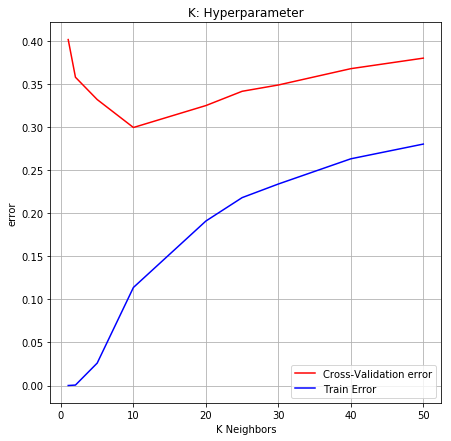

In [15]:
import scipy
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

neighbors = [1,2,5,10,20,25,30,40,50]
auc_scores_cv = []
auc_scores_train = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(Xtrain_res,ytrain_res) # fitting the model
    
    cv_predict = knn.predict_proba(Xcross_bow_std) # predicting the probabilistic values cross validation set
    cv_auc = roc_auc_score(y_cv,cv_predict[:,1])
    auc_scores_cv.append(cv_auc) #auc value for CV set
    
    train_predict = knn.predict_proba(Xtrain_bow_std) # predicting on train itself
    train_auc = roc_auc_score(y_train,train_predict[:,1]) # auc value for train
    auc_scores_train.append(train_auc)

print('Train AUC Scores ',auc_scores_train)
print('CV AUC Scores',auc_scores_cv)
error_cv = [1-  x for x in auc_scores_cv]
error_train = [1 - x for x in auc_scores_train]
# Visualising Train error and Cross Validation Error
plt.figure(figsize=(7,7))
plt.plot(neighbors,error_cv,color = 'r',label='Cross-Validation error') 
plt.plot(neighbors,error_train,color='b',label='Train Error')
plt.xlabel('K Neighbors')
plt.ylabel('error')
plt.title('K: Hyperparameter')
plt.legend(loc='lower right')
plt.grid()
plt.show()



In [16]:
# The optimal value of K
best_k =10

1. Initial model is overfitting as it should be. Train error is low and Validation error is high.

2. The train error keeps increasing and peeks at 50. Validation error decreases till k =10 and then increases gradually. 
   The model starts to underfit.

3. The optimal value of k is for which Crosh Validation error is low and train error close to CV error
 This can be seen for K=10.

# [3.2.5] Prediction & Performance Metrics



- The performance metric we are using is ROC and AUC.
- The dataset is highly imbalanced and binary hence ROC and AUC seem to be the optimal metric.
- We will also take a look at the confusion matrix to better understand the working of the model

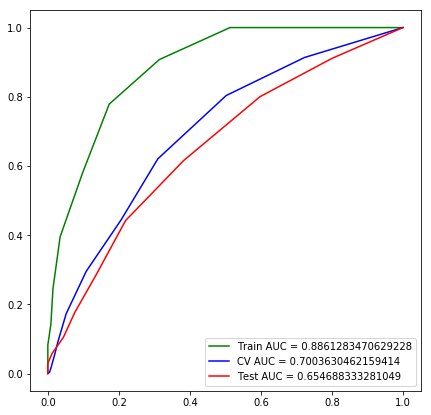

Train:
 [[ 342 1431]
 [   5  463]]

CV:
 [[202 737]
 [ 11 154]]

Test:
 [[ 232 1151]
 [  19  246]]
##################################################
TNR for Test =  0.9243027888446215
FPR for Test =  0.07569721115537849


In [17]:
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix
# Final Prediction using Test Data
knn = KNeighborsClassifier(n_neighbors = best_k)
knn.fit(Xtrain_res,ytrain_res) # fitting the model in train set

# predicted values determination
predicted_values_train = knn.predict_proba(Xtrain_bow_std)
predicted_values_test = knn.predict_proba(Xtest_bow_std)
predicted_values_cv = knn.predict_proba(Xcross_bow_std)

# False Positive Rate and True Positive Rate
train_fpr,train_tpr,thresholds = roc_curve(y_train,predicted_values_train[:,1],pos_label=1)
cv_fpr,cv_tpr,thresholds = roc_curve(y_cv,predicted_values_cv[:,1],pos_label=1)
test_fpr,test_tpr,thresholds = roc_curve(y_test,predicted_values_test[:,1],pos_label=1)

# Visualising ROC
plt.figure(figsize=(7,7))
plt.plot(train_fpr,train_tpr,color='g',label='Train AUC = '+str(auc(train_fpr,train_tpr)))
plt.plot(cv_fpr,cv_tpr,color='b',label = 'CV AUC = '+str(auc(cv_fpr,cv_tpr)))
plt.plot(test_fpr,test_tpr,color='r',label = 'Test AUC = '+str(auc(test_fpr,test_tpr)))
plt.legend(loc = 'lower right')
plt.show()

# Confucion Matrix

print('Train:\n',confusion_matrix(y_train,knn.predict(Xtrain_bow_std)).T)
print('\nCV:\n',confusion_matrix(y_cv,knn.predict(Xcross_bow_std)).T)
print('\nTest:\n',confusion_matrix(y_test,knn.predict(Xtest_bow_std)).T)
cm = confusion_matrix(y_test,knn.predict(Xtest_bow_std)).T
print('#'*50)
print('TNR for Test = ',(cm[0][0])/(cm[0][0] + cm[1][0]) )
print('FPR for Test = ',cm[1][0]/(cm[1][0]+cm[0][0]) )


1. The Test AUC is 65%. The model seems fine.
2. TNR = 92.4% which is very good.
3. FPR = 0.07% which again is very good.

**Conclusion: Overall, this model is a fairly good model. Using this model we are easily able to predict if a review is negative or not. For an internet company like amazon identifying negative comments are more important for which our True negative rate must be high and our False positive rate must be low. We are able to easily achieve that.** 


